<a href="https://colab.research.google.com/github/PedroABull/MPV_Split_1_PedroBull/blob/main/PedroABull_MVP_Split_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previsão de consumo de combustível em automóveis

A base de dados Auto-MPG contém informações sobre veículos fabricados entre 1970 e 1982 nas regiões do USA, JPN e EUR. O objetivo deste projeto é construir um modelo de regressão para prever a eficiência de combustível de um veículo, medida em milhas por galão (MPG - miles per gallon), com base em características mecânicas e de fabricação. A descrição das features da base de dados segue abaixo:

1. **Milhas por galão (mpg)**: Variável target que indica a eficiência do veículo.
2. **Cilindros (cylinders)**: Indica o número de cilindros no motor do veículo, sendo esse um parâmetro da dinâmica de motores que influencia diretamente no consumo de combustível
3. **Deslocamento (displacement)**: Refere-se ao volume total deslocado pelos pistões dentro dos cilindros do motor, medido em centímetros cúbicos.
4. **Potência (horsepower)**: Potência do motor medida em HPs.
5. **Peso (weight)**: O peso total do veículo.
6. **Aceleração (acceleration)**: Mede o tempo necessário para o veículo acelerar de 0 a 60 milhas por hora.
7. **Ano do Modelo (model year)**: O ano de fabricação do veículo.
8. **Origem (origin)**: Representa o país de origem do veículo. O dataset contém os valores 1 (EUA), 2 (Europa) e 3 (Japão).
9. **Nome do Carro (car name)**: O nome ou modelo do carro.


## Carregar dados

In [1]:
# Importando as bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate # para executar a validação cruzada
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error # métrica de avaliação MSE
from sklearn.metrics import r2_score # métrica de avaliação MSE
from sklearn.linear_model import LinearRegression # algoritmo Regressão Linear
from sklearn.linear_model import Ridge # algoritmo Regularização Ridge
from sklearn.linear_model import Lasso # algoritmo Regularização Lasso
from sklearn.neighbors import KNeighborsRegressor # algoritmo KNN
from sklearn.tree import DecisionTreeRegressor # algoritmo Árvore de Regressão
from sklearn.svm import SVR # algoritmo de SVR


# Caminho para a base no GitHub
DADOS = r'https://raw.githubusercontent.com/PedroABull/MPV_Split_1_PedroBull/refs/heads/main/auto-mpg.csv'

In [2]:
# Importando a base de dados
base = pd.read_csv(DADOS)

In [3]:
# Visualizando a base de dados
base.head(3)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite


## Data Cleaning

Após o carregamento dos dados, etapa de data cleaning tem o objetivo de avaliar principalmente a consistência da base de dados, se existem valores nulos e, também, se a formatação de cada uma das colunas corresponde ao esperado.

In [4]:
# Visualizando as informações da base
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


Inicialmente, a base de dados não apresenta valores nulos, como mostra a descrição acima. Porém, avaliando o tipo de feature, pode-se notar uma inconsistência na coluna "horsepower", a qual contém a informação de potência do motor em HPs e está formatada como uma coluna de textos.

Possivelmente esse erro foi causado por algum erro no preenchimento de informações, já que o esperado é que coluna horsepower seja numérica, com informções tipo int64 ou float64. Abaixo é apresentada a análise do problema.

In [5]:
# Definindo lista vazia para armazenar os valores de erro da coluna horsepower
lista_erros = []

# Avaliando quais os erros de preenchimento da coluna horsepower e printando quantos e quais são
for w in base['horsepower'].unique():
    try:
        int(w)
    except ValueError:
        lista_erros.append(w)
        print("Erro encontrado {} vezes: {}".format(base.loc[base['horsepower'] == "?", 'horsepower'].count(), w))

Erro encontrado 6 vezes: ?


Foram encontrados 6 registros com o valor "?", o que indica que este foi usado para identificar as situações nas quais não se tinha a informação sobre a potência do motor do veículo.

Nesse caso, como o número de erros é pequeno, a exclusão dessas linhas poderia ser adotada como uma estratégia factível para a resolução do problema. No entanto, como a base de dados já é enxuta, optei por manter as linhas e substituir as informações faltantes por uma estimativa. Dessa forma, a base de dados não será reduzida e o tratamento dessas inconsistências já fica parametrizado para possíveis novos erros contidos em novos dados fornecidos para o modelo no futuro.

Sendo assim, irei substituir os erros por valores nulos e, após a análise exploratória dos dados, finalizar o enriquecimento da base. Com isso, a ideia é avaliar quais as melhores variáveis para se estimar a potência do motor com base no restante dos atributos.

In [6]:
# Substituindo os erros por valores nulos
for i, item in enumerate(base.horsepower):
    if item in lista_erros:
        base.loc[base['horsepower'] == item ,  'horsepower'] = np.nan
        base['horsepower'] = base['horsepower'].astype('float')
    else:
        pass

In [7]:
# Validando a modificação
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(4), int64(4), object(1)
memory usage: 28.1+ KB


Após a modificação, a descrição da base de dados apresenta a cluna horsepower como uma coluna numérica e com 6 valores nulos, que é exatamente o que se esperava após a última operação de tratamento da base.

## Análise Exploratória

Após a limpeza dos dados, essa etapa servirá principalmente para entender como os dados se correlacionam de modo geral e, também, para avaliar quais os atributos seguirão para o modelo (Feature Selection).

O primeiro passo é avaliar a cardinalidade dos dados. Esse é um parâmetro relevante principalmente em colunas de texto e/ou categóricas, nas quais a alta cardinalidade pode ser um indicativo de que tal informação pode não ter tanta relevância para as previsões.

In [8]:
# Avaliando a cardinalidade das colunas
print(base.nunique())

mpg             129
cylinders         5
displacement     82
horsepower       93
weight          351
acceleration     95
model year       13
origin            3
car name        305
dtype: int64


A coluna 'car name' possui 305 valores distintos em 380 registros, ou seja, possui cardinalidade elevada. Com isso, da maneira que está, essa coluna não agrega nenhum valor à análise. Porém, a partir da visualização da base de dados na etapa de carregamento, pode-se perceber que a coluna 'car name' possui certo padrão, no qual a primeira palavra refere-se ao nome da montadora e o restante ao modelo do veículo. Tais informações podem ser úteis para completar os dados faltantes na coluna 'horsepower' e, por isso, a coluna 'car name' ainda não será excluida.

Em seguida, abaixo segue a descrição estatística dos dados.

In [9]:
# Descrição estatística dos dados
with pd.option_context("display.float_format", "{:.2f}".format):
    display(base.describe())

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
count,398.00,398.00,398.00,392.00,398.00,398.00,398.00,398.00
mean,23.51,5.45,193.43,104.47,2970.42,15.57,76.01,1.57
std,7.82,1.70,104.27,38.49,846.84,2.76,3.70,0.80
min,9.00,3.00,68.00,46.00,1613.00,8.00,70.00,1.00
25%,17.50,4.00,104.25,75.00,2223.75,13.83,73.00,1.00
50%,23.00,4.00,148.50,93.50,2803.50,15.50,76.00,1.00
75%,29.00,8.00,262.00,126.00,3608.00,17.18,79.00,2.00
max,46.60,8.00,455.00,230.00,5140.00,24.80,82.00,3.00


Podemos extrair os seguintes insights da descrição estatística dos dados:

- Nenhuma das colunas, a princípio, parece ter outliers reais(valores que de fato fogem muito do padrão).

- Possívelmente existem outliers matemáticos em função da natureza do cálculo, do tamanho reduzido da base e da distribuição dos dados mas, a princípio, são dados compatíveis com a realidade do problema.

- Existe uma diferença de escala considerável entre alguns dos atributos. Com isso, será necessário fazer um ajuste de escala para evitar interferências no modelo como, por exemplo, para evitar que o mesmo aplique um peso maior para variáveis que possuem uma maior valor absoluto por natureza.

Agora, avaliando a correlação entre os atributos.

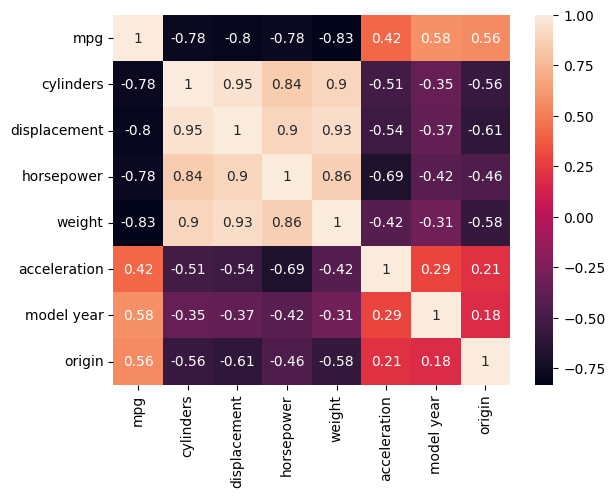

In [10]:
# Avaliando a correlação entre os atributos
sns.heatmap(base.drop('car name', axis = 1).corr(), cmap = 'rocket', annot = True);

Como já esperado, os parâmetros mecânicos do motor relacionados com a potência do mesmo (potência, número de cilíndros e seus deslocamentos) e também o peso do veículo tem uma forte correlação negativa com a eficiência geral do veículo.

Além disso, o ano de fabricação e a região de origem também apresentam certa correlação, o que pode indicar:

- A evolução tecnológica ao longo dos anos fez com que os veículos ficassem mais eficientes, o que de fato é verdadeiro;

- A indústria de cada região tem suas características e, como exemplo, a indústria autoamotiva dos EUA é focada em carros mais pontentes, sem tanta preocupação com a eficiência.

Para avaliar esta última hipótese, optei por plotar um gráfico pairplot para apresentar a correlação dos dados com a coluna 'origin' de maneira mais visual. Para facilitar a compreensão, transformei os valores numéricos em siglas para representar cada uma das regiões, as quais servirão também para a etapa de feature engineering.

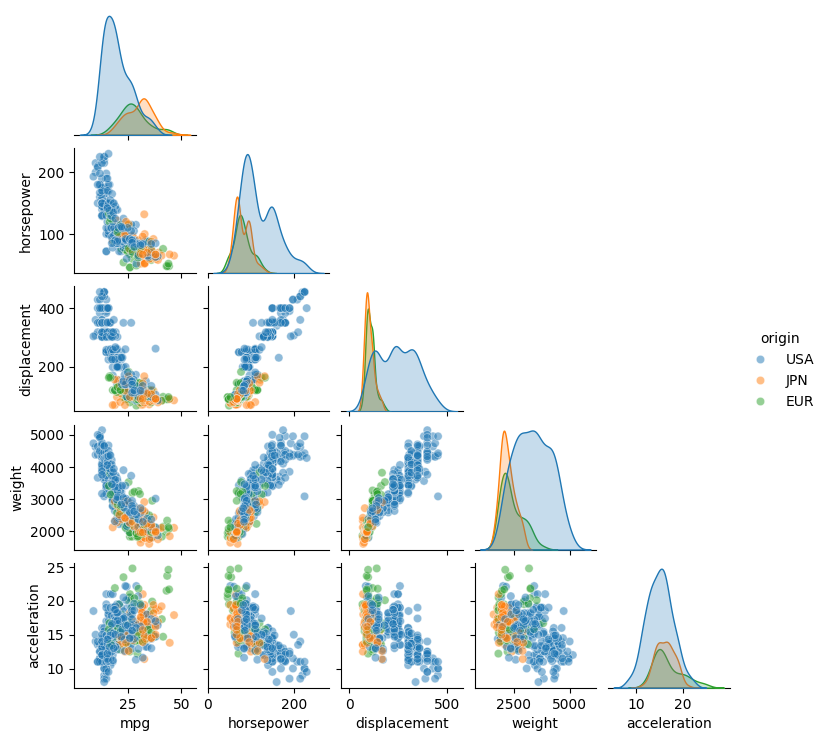

In [11]:
# Modificando "origin" para os rótulos em texto da região de origem
origem = {1:"USA", 2:"EUR", 3:"JPN"}
base.origin = base.origin.map(origem)

# Plotando o pairplot das variáveis
pairplot_columns = ['mpg', 'horsepower', 'displacement', 'weight', 'acceleration', 'origin']

sns.pairplot(
    base[pairplot_columns],
    diag_kind = 'kde',
    hue= 'origin',
    plot_kws=dict(alpha=0.5),
    corner=True,
    palette='tab10',
    height=1.5,
    aspect=1
    );

Assim como os parâmetros do motor e o peso do veículo, os gráficos da diagonal principal mostram que os parâmetros do veículo, de maneira geral, são influenciados diretamente por sua região de origem, especialmente o gráfico que correlaciona a coluna 'mpg' com a coluna 'origin'. Com isso, pode-se afirmar que cada uma das regiões tem seu viés na fabricação dos veículos.

No que diz respeito aos outliers, optei por gerar uma visualização gráfica da distibuição dos dados para avaliar se de fato existem outliers matemáticos na base e se faz senti mantê-los.

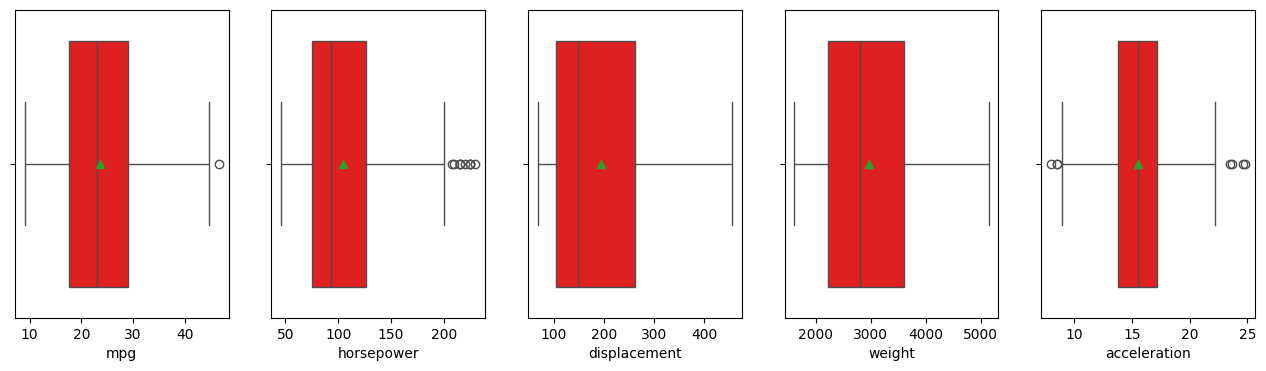

In [12]:
# Definindo colunas para os gráficos
cols = ['mpg', 'horsepower', 'displacement', 'weight', 'acceleration']

# Avaliando os outliers
fig, axs = plt.subplots(1, len(cols), figsize = (16,4))

for ax, column in zip(axs, cols):
    sns.boxplot(x=column, data=base, ax=ax, showmeans = True, color='red')

plt.show()

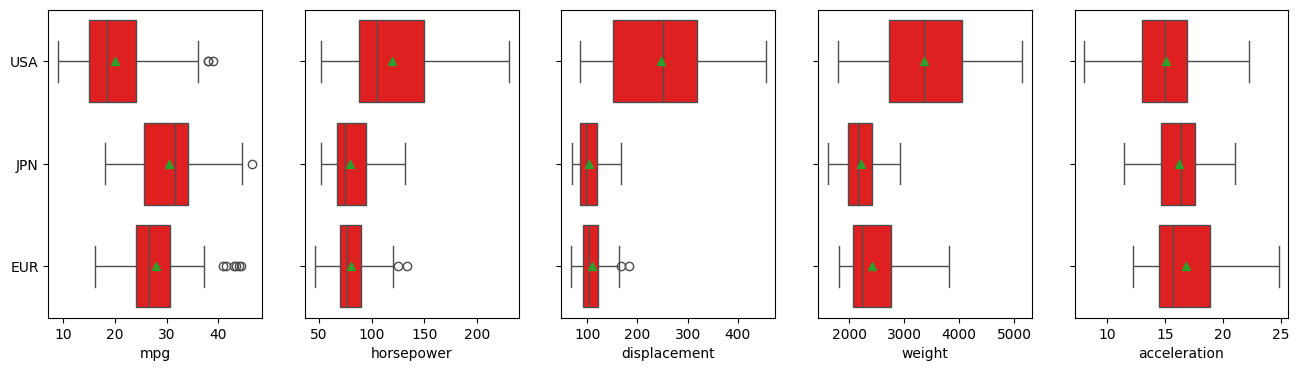

In [13]:
# Avaliando os outliers
fig, axs = plt.subplots(1, len(cols), figsize = (16,4), sharey = True)

for ax, column in zip(axs, cols):
    sns.boxplot(x=column, data=base, ax=ax, showmeans = True, y='origin', color='red')
    ax.set_ylabel("")

plt.show()

De fato, existem dados que extrapolam os limites inferior e/ou superior dos gráficos para alguns dos atributos. Todavia, esses são valores factíveis para o problema e representam apenas veículos que fogem um pouco da média das amostras presentes na base de dados. Com uma base de dados relativamente pequena como essa, facilmente veículos um pouco mais potentes, por exemplo, ou um pouco mais eficientes do que a média já podem ser considerados matematicamente como outliers. Com isso, nenhum outlier será retirado do modelo.

## Feature Engineering

Finalizado o entendimento dos dados, o próximo passo é desenvolver a engenharia de recursos para preparar os dados a serem consumidos pelos modelos.

Retomando a discussão sobre a coluna 'car name', fazendo a separação das informações entre fabricante (maker) e modelo (model), temos:




In [14]:
# Separando fabricante(maker) e modelo(model) a partir da coluna car name
base[['maker', 'model']] = base['car name'].str.split(" ", n=1, expand=True)
base = base.drop('car name', axis = 1)

In [15]:
# Avaliando a base de dados
base.head(3)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,maker,model
0,18.0,8,307.0,130.0,3504,12.0,70,USA,chevrolet,chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,USA,buick,skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,USA,plymouth,satellite


In [16]:
# Avaliando a coluna de fabricantes
print(base.maker.value_counts())

maker
ford             51
chevrolet        43
plymouth         31
amc              28
dodge            28
toyota           25
datsun           23
buick            17
pontiac          16
volkswagen       15
honda            13
mercury          11
mazda            10
oldsmobile       10
fiat              8
peugeot           8
audi              7
chrysler          6
vw                6
volvo             6
renault           5
saab              4
subaru            4
opel              4
chevy             3
bmw               2
cadillac          2
maxda             2
mercedes-benz     2
triumph           1
vokswagen         1
mercedes          1
hi                1
capri             1
chevroelt         1
toyouta           1
nissan            1
Name: count, dtype: int64


In [17]:
# Correção de erros de digitação no nome das marcas
name_corr = {
    "chevroelt": "chevrolet",
    "chevy": "chevrolet",
    "vokswagen": "volkswagen",
    "vw": "volkswagen",
    "hi": "harvester",
    "maxda": "mazda",
    "toyouta": "toyota",
    "mercedes-benz": "mercedes",
}

# Substituindo os valores com digitação errada
base["maker"] = base["maker"].replace(name_corr)

Mesmo como a separação da coluna 'car name' entre 'maker' e 'model', optei por não utiliza-las para a correção da coluna 'horsepower'. Isso se dá pois a quantidade de resgistros por fabricante acaba sendo pequena, muitas vezes única, então um cálculo estatístico para a potência com base nesses poucos dados certamente estaria enviesado. Para uma base com um maior valume de dados, a coluna maker seria utilizada no processo de correção, já que motores do mesmo fabricante com as mesmas características tendem a ter valores de potência semelhantes.

No entando, já foi discutido que cada região de origem apresenta um foco para a produção de veículos. Com isso, é realista considerar que todas as montadoras de uma mesma região tenham veículos com características semelhantes. Assim, escolhi a coluna 'origin' como uma das opções para a correção dos dados faltantes na coluna 'horsepower'.

Para essa correção, agrupei as informações de região de origem, número de cilindros e ano de fabricação. A partir desse agrupamento, substitui os valores faltantes pelo valor da mediana da potência do cluster em qual o veículo com a informação faltante se encaixa.

A escolha pela mediana foi feita para que o valor substituido seja, de fato, um valor de potência que existe, uma vez que se o agrupamento for resumido pela média, por exemplo, há uma grande probabilidade de que o valor estimado para potência seja um valor fictício, ou seja, se que não exista um motor real com aquele valor de potência.

Abaixo segue um exemplo:




In [18]:
# Agrupando os dados somente para 'origin' = USA e veículos com motor de 4 cilindros
base.loc[(base['origin'] == 'USA') & (base['cylinders'] == 4)].groupby(['origin', 'cylinders', 'model year'])['horsepower'].median()

origin  cylinders  model year
USA     4          71            79.0
                   72            86.0
                   73            78.5
                   74            75.0
                   75            80.5
                   76            72.0
                   77            85.5
                   78            80.0
                   79            80.0
                   80            90.0
                   81            74.5
                   82            85.5
Name: horsepower, dtype: float64

In [19]:
# Exibindo o primeiro valor nulo da base
base.loc[base['horsepower'].isnull()].head(1)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,maker,model
32,25.0,4,98.0,NaN,2046,19.0,71,USA,ford,pinto


A partir da tabela de agrupamento e da linha com registro de 'horsepower' nulo exibidos acima, temos que o valor faltante deve, seguindo a tabela, ser substituido por 79. No entando, se a métrica usada fosse a média, o valor substituido seria de 79.5 HPs, o qual não é um valor nominal para potência de motores.

Portanto, abaixo segue o tratamento final da coluna horsepower.

In [20]:
# Tratando valores nulos da coluna horsepower
base.loc[base['horsepower'].isnull(), 'horsepower'] = base.groupby(['origin', 'cylinders', 'model year'])['horsepower'].transform(lambda x: x.fillna(x.median()))

Em seguida, foi aplicado o OneHotEncoder na coluna 'origin' para que ela possa ser utilizada no modelo.

In [21]:
# Transformando as colunas de texto em colunas numéricas com o OneHotEnconder
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc = enc.fit(base[['origin']])
enc_df = pd.DataFrame(enc.transform(base[['origin']]).toarray())
enc_df.columns = enc.categories_[0]

base = pd.concat([base.drop(['maker', 'model', 'origin'], axis = 1), enc_df], axis = 1)

Por fim, foi aplicado um normalizador nos dados numéricos para ajuste de escala. O objetivo aqui é ajustar a escala dos dados para evitar que os modelos considerem variáveis de maior escala como sendo mais importantes.

Avaliando as features numéricas, temos que todas tem natureza ordinária, ou seja, a ordem de grandeza dos dados carrega informação. Por exemplo, uma potência menor do motor significa que o motor é mais fraco do que um motor com maior potência. Esse conceito foi considerado na escolha de um normalizador, a qual foi feita justamente para preservar essas características. Assim, o algoritmo escolhido foi o MinMaxScaler, o qual mantém a natureza da distribuição dos dados, ajustando somente a escala.

Também foram feitos testes com abordagens diferentes de padronização e normalização, mas o MinMaxScaler foi o que obteve o melhor resultado para esse projeto. Abaixo segue a implementação deste algoritmo.


In [22]:
# Criando o objeto normalizador
scaler = MinMaxScaler()

# Normalizando os dados
scaler.fit(base[['displacement', 'horsepower', 'weight', 'cylinders', 'acceleration', 'model year']])

# Tranformando a saída do normalizador em um dataframe
df_padrao = scaler.transform(base[['displacement', 'horsepower', 'weight', 'cylinders', 'acceleration', 'model year']])
df_padrao = pd.DataFrame(df_padrao)
df_padrao.columns = scaler.get_feature_names_out() + "_norm"

# Unindo os resultados do normalizador com o restante do dataframe
base = pd.concat([base.drop(['displacement', 'horsepower', 'weight', 'cylinders', 'acceleration', 'model year'], axis = 1), df_padrao], axis = 1)

# Visualizando a saída
base.head(3)

,mpg,EUR,JPN,USA,displacement_norm,horsepower_norm,weight_norm,cylinders_norm,acceleration_norm,model year_norm
0,18.0,0.0,0.0,1.0,0.617571,0.456522,0.536150,1.0,0.238095,0.0
1,15.0,0.0,0.0,1.0,0.728682,0.646739,0.589736,1.0,0.208333,0.0
2,18.0,0.0,0.0,1.0,0.645995,0.565217,0.516870,1.0,0.178571,0.0


## Criando o modelo

Nessa etapa do projeto, a partir de todas as análises realizadas até aqui, o objetivo é definir alguns modelos diferentes e testar qual tem a melhor performance com o conjunto de dados disponível.

Em suma, o passo a passo que será realizado é:

1. Separar dos dados em treino e teste
2. Realizar Validação Cruzada e avaliar a performance de cada modelo
3. Fazer o GridSearch para otimização de hiperparâmetros
4. Testar cada modelo com a base de testes
5. Selecionar o melhor modelo

Como métricas para avaliação de performance, foram escolhidas:

- R²: Para avaliar o quanto cada modelo se ajusta aos dados disponíveis. Essa métrica foi escolhida com o objetivo de dar suporte às análises.

- RMSE: Para avaliar, em escala, qual a magnitude média do erro de previsão de cada modelo. Essa é a métrica principal para seleção do modelo justamente pelo fato de fornecer uma referência média de quanto o modelo está errando em relação ao valor real.

In [23]:
# Separar dados em treino e teste
test_size = 0.2 # tamanho do conjunto de teste
seed = 42 # semente aleatória

# Separando dados de features e target
X = base.drop('mpg', axis = 1)
y = base.mpg
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True, random_state=seed)       # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = ['r2', 'neg_mean_squared_error', 'neg_root_mean_squared_error']
num_particoes = 5
kf = KFold(n_splits = num_particoes, shuffle=True, random_state=seed)

In [24]:
# Lista que armazenará os modelos e resultados
models = []
results = {}

# Preparando os modelos e adicionando-os em uma lista
models.append(('LR', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('SVR', SVR()))


# Avaliando a perfomance dos modelos
for name, model in models:
  cv_results = cross_validate(model, X_train, y_train, cv=kf, scoring = scoring)
  results.update({name : cv_results})

# Transformando os resultados em um dataframe
df_results = pd.DataFrame(results).T.reset_index().rename(columns={'index':'model' ,'test_neg_mean_squared_error':'test_MSE', 'test_neg_root_mean_squared_error':'test_RMSE'})
df_results = df_results.explode(df_results.columns[1:].tolist())                                                                                                                          # Transformando os arrays em linhas do dataframe
df_results[df_results.columns[1:]] = df_results[df_results.columns[1:]].abs()                                                                                                             # Transformando todos os valores numéricos em valor absoluto

# Transformando os dados em números para criar as visualizações
df_results = df_results.apply(pd.to_numeric, errors='ignore')

<ipython-input-24-de7afbca5eb8>:25: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_results = df_results.apply(pd.to_numeric, errors='ignore')


Visualizando gráficamente os resultados da validação cruzada:

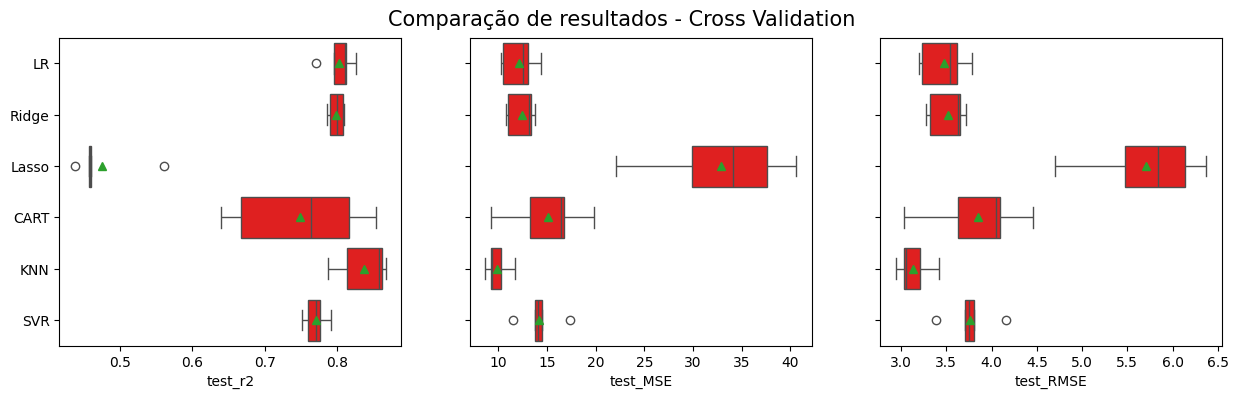

In [25]:
# Definindo uma variável com as colunas para o gráfico
cols = ['test_r2', 'test_MSE', 'test_RMSE']

# Visualizando graficamente os resultados da validação cruzada
fig, axs = plt.subplots(1, len(cols),figsize=(15, 4), sharey = True)

for ax, column in zip(axs, cols):
    sns.boxplot(x=column, ax=ax, data=df_results, y='model', showmeans = True, color='red')
    ax.set_ylabel("")
    # Configurar a área de plotagem (remover fundo branco)

# Adicionar título único ao gráfico
fig.suptitle('Comparação de resultados - Cross Validation', fontsize=15, y=0.95)

plt.show()

A princípio, boa parte dos modelos performou relativamente bem nos dados de treino, com exceção da Regressão L1.

O próximo passo é realizar a otimização dos hipeparâmetros para extrair o máximo de performance de cada um dos modelos. Para isso, foi criado um dicionário suporte para armazenar tanto o melhor modelo indicado pelo algoritmo otmizador quanto os resultados das métricas que cada modelo obteve. Esse dicionário será usado como suporte na etapa de teste dos modelos para substituir os modelos iniciais da lista 'modelos', os quais não contém hiperparâmetros otimizados.

Todos os valores configurados no GridSearch para os hiperparâmetros foram escolhidos com base na experiência de aplicação em outros problemas de natureza semelhante.

In [26]:
# Dicionário de hiperparâmetros para otimização
hiper = {'LR' : {}, 'Ridge' : {'alpha': np.logspace(-4, 4, 50), 'max_iter': [1000, 5000, 10000], 'tol': [1e-3, 1e-4]}, 'Lasso' : {'alpha': np.logspace(-4, 4, 50)}, 'CART' : {'max_depth': [3, 5, 10, 15, 20], 'min_samples_split': [2, 5, 10, 15], 'min_samples_leaf': [1, 2, 5, 10]}, 'KNN' : {'n_neighbors': np.arange(1, 15), 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan', 'minkowski']}, 'SVR' : {'kernel' : ['rbf', 'sigmoid'], 'epsilon' : [0.1, 0.01, 1.0], 'C' : [0.1, 1.0, 10]}}

# Dicionário para armazenar os resultados da otimização
hiper_results = {}

# Loop para percorrer a lista de modelos e realizar a otimização de cada um sucessivamente
for nome, modelo in models:
    # Modelo Grid com a métrica de RMSE
    reg_gs = GridSearchCV(modelo, hiper[nome], cv=5, scoring='neg_root_mean_squared_error')

    # Fazendo o fit do modelo
    reg_gs.fit(X_train, y_train)

    # Guardando os resultados no dicionário
    hiper_results[nome] = [reg_gs.best_estimator_, abs((reg_gs.best_score_))]

# Visualizando os resultados do GridSearchCV
hiper_results

{'LR': [LinearRegression(), 3.4597559652614516],
 'Ridge': [Ridge(alpha=0.12648552168552957, max_iter=1000, tol=0.001),
  3.4547373409898037],
 'Lasso': [Lasso(alpha=0.0062505519252739694), 3.4576739160900045],
 'CART': [DecisionTreeRegressor(max_depth=10, min_samples_leaf=10),
  3.428784997253993],
 'KNN': [KNeighborsRegressor(metric='manhattan', n_neighbors=9, weights='distance'),
  2.958731035956629],
 'SVR': [SVR(C=10, epsilon=1.0), 2.9391078812660325]}

Com a otimização, pode-se perceber que o o algoritmo SVR teve uma melhora significativa, se equiparando ao KNN, enquanto os outros algoritmos não obtiveram melhoras tão relevantes.

Iniciando a fase de teste dos modelos, temos os seguintes resultados:

In [27]:
# Tranformando a lista inicial de modelos em um dicionário
models_dict = {}
for i in range(len(models)):
    models_dict[models[i][0]] = models[i][1]

# Criando uma lista para armazenar as predições de cada um dos modelos
lista_predicoes = []

# Loop para treinar, realizar as predições e avaliar os modelos com os dados de teste
for modelo in models_dict:

  # Substituindo os modelos iniciais pelos modelos com os hiperparamêtros otimizados
  models_dict[modelo] = hiper_results[modelo][0]

  # Salvando o modelo em uma variável
  reg = models_dict[modelo]

  # Treinando o modelo
  reg.fit(X_train, y_train)

  # Realizando a predição com os dados de teste
  predictions = reg.predict(X_test)

  # Calculando o MSE
  rmse = np.sqrt(mean_squared_error(y_test, predictions))

  # Avaliar o modelo com a métrica R2
  r2 = r2_score(y_test, predictions)

  # Gravando resultados e predições
  lista_predicoes.append((modelo, predictions, r2, rmse))

  # Imprimindo os resultados para avaliação prévia
  msg = "%s: R2 %0.2f - RMSE %0.2f" % (modelo, r2, rmse)
  print(msg)

LR: R2 0.84 - RMSE 2.90
Ridge: R2 0.84 - RMSE 2.89
Lasso: R2 0.84 - RMSE 2.91
CART: R2 0.85 - RMSE 2.81
KNN: R2 0.91 - RMSE 2.15
SVR: R2 0.93 - RMSE 1.97


Avaliando os resultados, temos que o algoritmo SVR obteve o melhor resultado, chegando a um erro médio de previsão de 1.97 mpg.

Vale destacar que os modelos melhoraram o desempenho na fase de testes quando comparados à fase de validação cruzada, muito em função do maior volume de dados disponíveis para essa etapa.

A diante, a discussão sobre os resultados será aprofundada, seguida pela conclusão do projeto.

## Resultados

Na etapa de resultados, o objetivo é apresentar a performance dos modelos de forma gráfica e fazer comparativos mais aprofundados.

A imagem abaixo mostra visualmente como cada modelo performou em relação aos valores de eficiência que eram esperados. Para isso, foi traçada uma reta de referência y = x, ou seja, uma reta que simula o cenário em que o valor predito é igual ao valor real de target. Dessa forma, quanto mais próxima da reta for a distribuição dos pontos, melhor o desempenho do modelo.

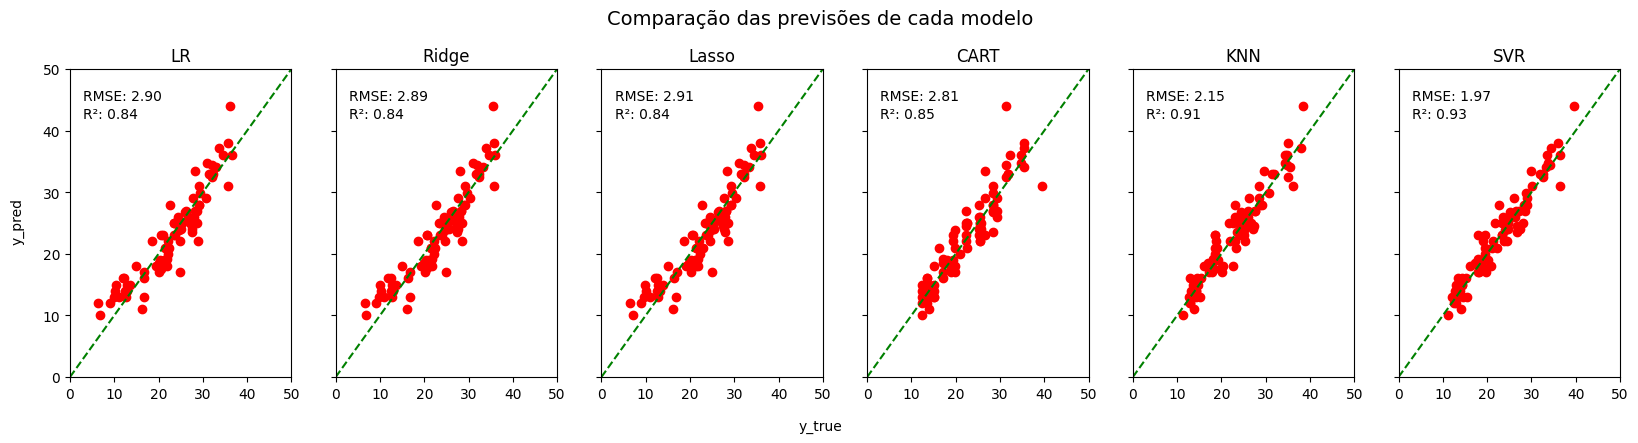

In [28]:
# Comparando graficamente as predições de cada modelo
fig, ax = plt.subplots(ncols = 6, nrows = 1, figsize=(20, 4), sharey = True)

for i in range(6):

  # Configurações de cada gráfico
  ax[i].scatter(lista_predicoes[i][1], y_test, color='red')
  ax[i].plot([0, 50], [0, 50], "--g")
  ax[i].set(xlim = (0, 50), ylim = (0, 50))
  ax[i].set_title(lista_predicoes[i][0])
  ax[i].text(x = 3, y=45, s="RMSE: {:.2f}".format(lista_predicoes[i][3]))
  ax[i].text(x = 3, y=42, s="R²: {:.2f}".format(lista_predicoes[i][2]))


# Adicionar títulos únicos ao gráfico
fig.suptitle('Comparação das previsões de cada modelo', fontsize=14, y=1.03)
fig.supxlabel('y_true', fontsize=10, y=-0.03)
fig.supylabel('y_pred', fontsize=10, x = 0.095, y=0.5)

plt.show()

In [29]:
# Exibindo os resultados da validação cruzada
df_results.groupby('model').mean()

,fit_time,score_time,test_r2,test_MSE,test_RMSE
model,,,,,
CART,0.007477,0.005572,0.748346,15.082651,3.852989
KNN,0.004614,0.010606,0.837830,9.841186,3.132603
LR,0.005209,0.007197,0.803306,12.132265,3.475737
Lasso,0.003889,0.005519,0.474306,32.870103,5.703317
Ridge,0.007786,0.008049,0.798775,12.412967,3.518515
SVR,0.022819,0.012810,0.770180,14.212477,3.761874


Resultados alcançados:

1. É perceptível que a dispersão dos pontos do modelo SVR, em relação à reta de referência, é considerávelmente menor do que os demais modelos.

2. Com o maior volume de dados disponíveis e, também, com a otimização dos hiperparâmetros, a regressão L1 se aproximou bastante da regressão L2, tendo o RMSE reduzido em mais de 50%, chegando a menos de 3 mpg na fase final de testes.

3. Antes da etapa de otimização, o algotimo KNN era o que estava performando melhor, com um RMSE de 2.30 mpg. Após a otimização, o algoritmo SVR melhorou sua performance consideravelmente, apesar de demorar o dobro do tempo de treinamento, em média, em relação ao KNN para processar os dados, como mostra a tabela com os resultados da validação cruzada. Ainda assim, todos os modelos processaram os dados com bastante celeridade.

## Conclusão

Ao final, o projeto alcançou resultados satisfatórios em relação aos tempos de processamento dos dados e, principalmente, para os resultados alcançados.

O modelo final escolhido para a resolução do problema foi o modelo SVR, o qual teve uma performance cerca de 8% melhor do que o segundo melhor modelo testado. O modelo SVR foi tanto o que se ajustou melhor aos dados de maneira geral, com um R² de 0.93, quanto o que teve o menor valor de erro, com um RMSE de 1.97 mpg.

Como um Mínimo Produto Viável, o projeto cumpre o seu papel entregando análises de dados consistentes e um modelo preditivo confiável. Do ponto de vista de melhorias, a única modificação que irei implementar é a estruturação de um pipeline para que o código fique mais bem estruturado e organizado. Para essa entrega inicial, por falta de tempo o pipeline não foi implementado.